# DETR (Detection Transformer)

## Overview
DETR revolutionizes object detection by integrating a transformer model, traditionally used in natural language processing, into the realm of computer vision. It simplifies the object detection pipeline by eliminating the need for many hand-designed components.

## Motivation
DETR addresses the complexity and inefficiencies of prior object detection systems, offering a streamlined and theoretically elegant approach.

## DETR Architecture


![picture](https://drive.google.com/uc?export=view&id=118YC9lpqOZPc-NCeP5pspDvbKBt0aXNv)

## Overall Structure
DETR combines a Convolutional Neural Network (CNN) backbone with a transformer model. The CNN extracts features from input images, and the transformer processes these features to predict object classes and bounding boxes.

In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50, mobilenet_v3_small
import torchvision.transforms as T
torch.set_grad_enabled(False)

## Key Components of DETR
### CNN Backbone
Extracts feature maps from the input image. Commonly, ResNet is used for this purpose.

### Transformer Encoder-Decoder
**Encoder**

Processes the feature map from the CNN. It consists of self-attention and feed-forward layers.

**Decoder**

Generates object queries. Each query predicts an object in the image, using cross-attention with the encoder's output.

### Feed-Forward Networks
These networks predict the final class and bounding box for each object query.

## DETR Parameters and Configurations
### Model Parameters

Key parameters include the number of encoder and decoder layers, attention heads, and feed-forward network dimensions. DETR is trained with standard backpropagation using AdamW optimizer, learning rate scheduling, and a custom loss function. Techniques like dropout and layer normalization are used for stable training.

In [2]:
class DETR(nn.Module):

    def __init__(self, num_classes, hidden_dimensions=256, nheads = 8, num_encoder_layer=6, num_decoder_layer=6) -> None:
        super().__init__()

        self.backbone = resnet50()

        del self.backbone.fc

        self.conv = nn.Conv2d(2048, hidden_dimensions, 1)

        self.transformer = nn.Transformer(hidden_dimensions, nheads, num_encoder_layer, num_decoder_layer)

        self.linear_class = nn.Linear(hidden_dimensions, num_classes+1)

        self.linear_bbox = nn.Linear(hidden_dimensions, 4)

        self.query_pos = nn.Parameter(torch.rand(100, hidden_dimensions))

        self.row_embed = nn.Parameter(torch.rand(50, hidden_dimensions//2))

        self.col_embed = nn.Parameter(torch.rand(50, hidden_dimensions//2))


    def forward(self, inputs):

        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        h = self.conv(x)

        H, W = h.shape[-2:]

        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        h = self.transformer(pos + 0.1*h.flatten(2).permute(2,0,1), self.query_pos.unsqueeze(1)).transpose(0,1)

        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

## Working of DETR
### Object Detection Process
DETR treats object detection as a set prediction problem. Each decoder output corresponds to a prediction of an object.

### Sequence Modeling
The model processes the entire set of objects at once, in parallel, unlike traditional methods that process objects sequentially.

### Bipartite Matching and Loss Calculation
DETR uses the Hungarian algorithm for matching predicted and ground truth objects, calculating a combined loss of classification and bounding box regression.

In [3]:
detr = DETR(num_classes=91)

state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)

detr.load_state_dict(state_dict)

detr.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth
100%|██████████| 79.3M/79.3M [00:00<00:00, 83.8MB/s]


DETR(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [4]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [5]:
transform = T.Compose([T.Resize(800), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


In [17]:
def detect(im, model, transform):

    img = transform(im).unsqueeze(0)

    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    outputs = model(img)

    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]

    keep = probas.max(-1).values > 0.9

    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas[keep], bboxes_scaled

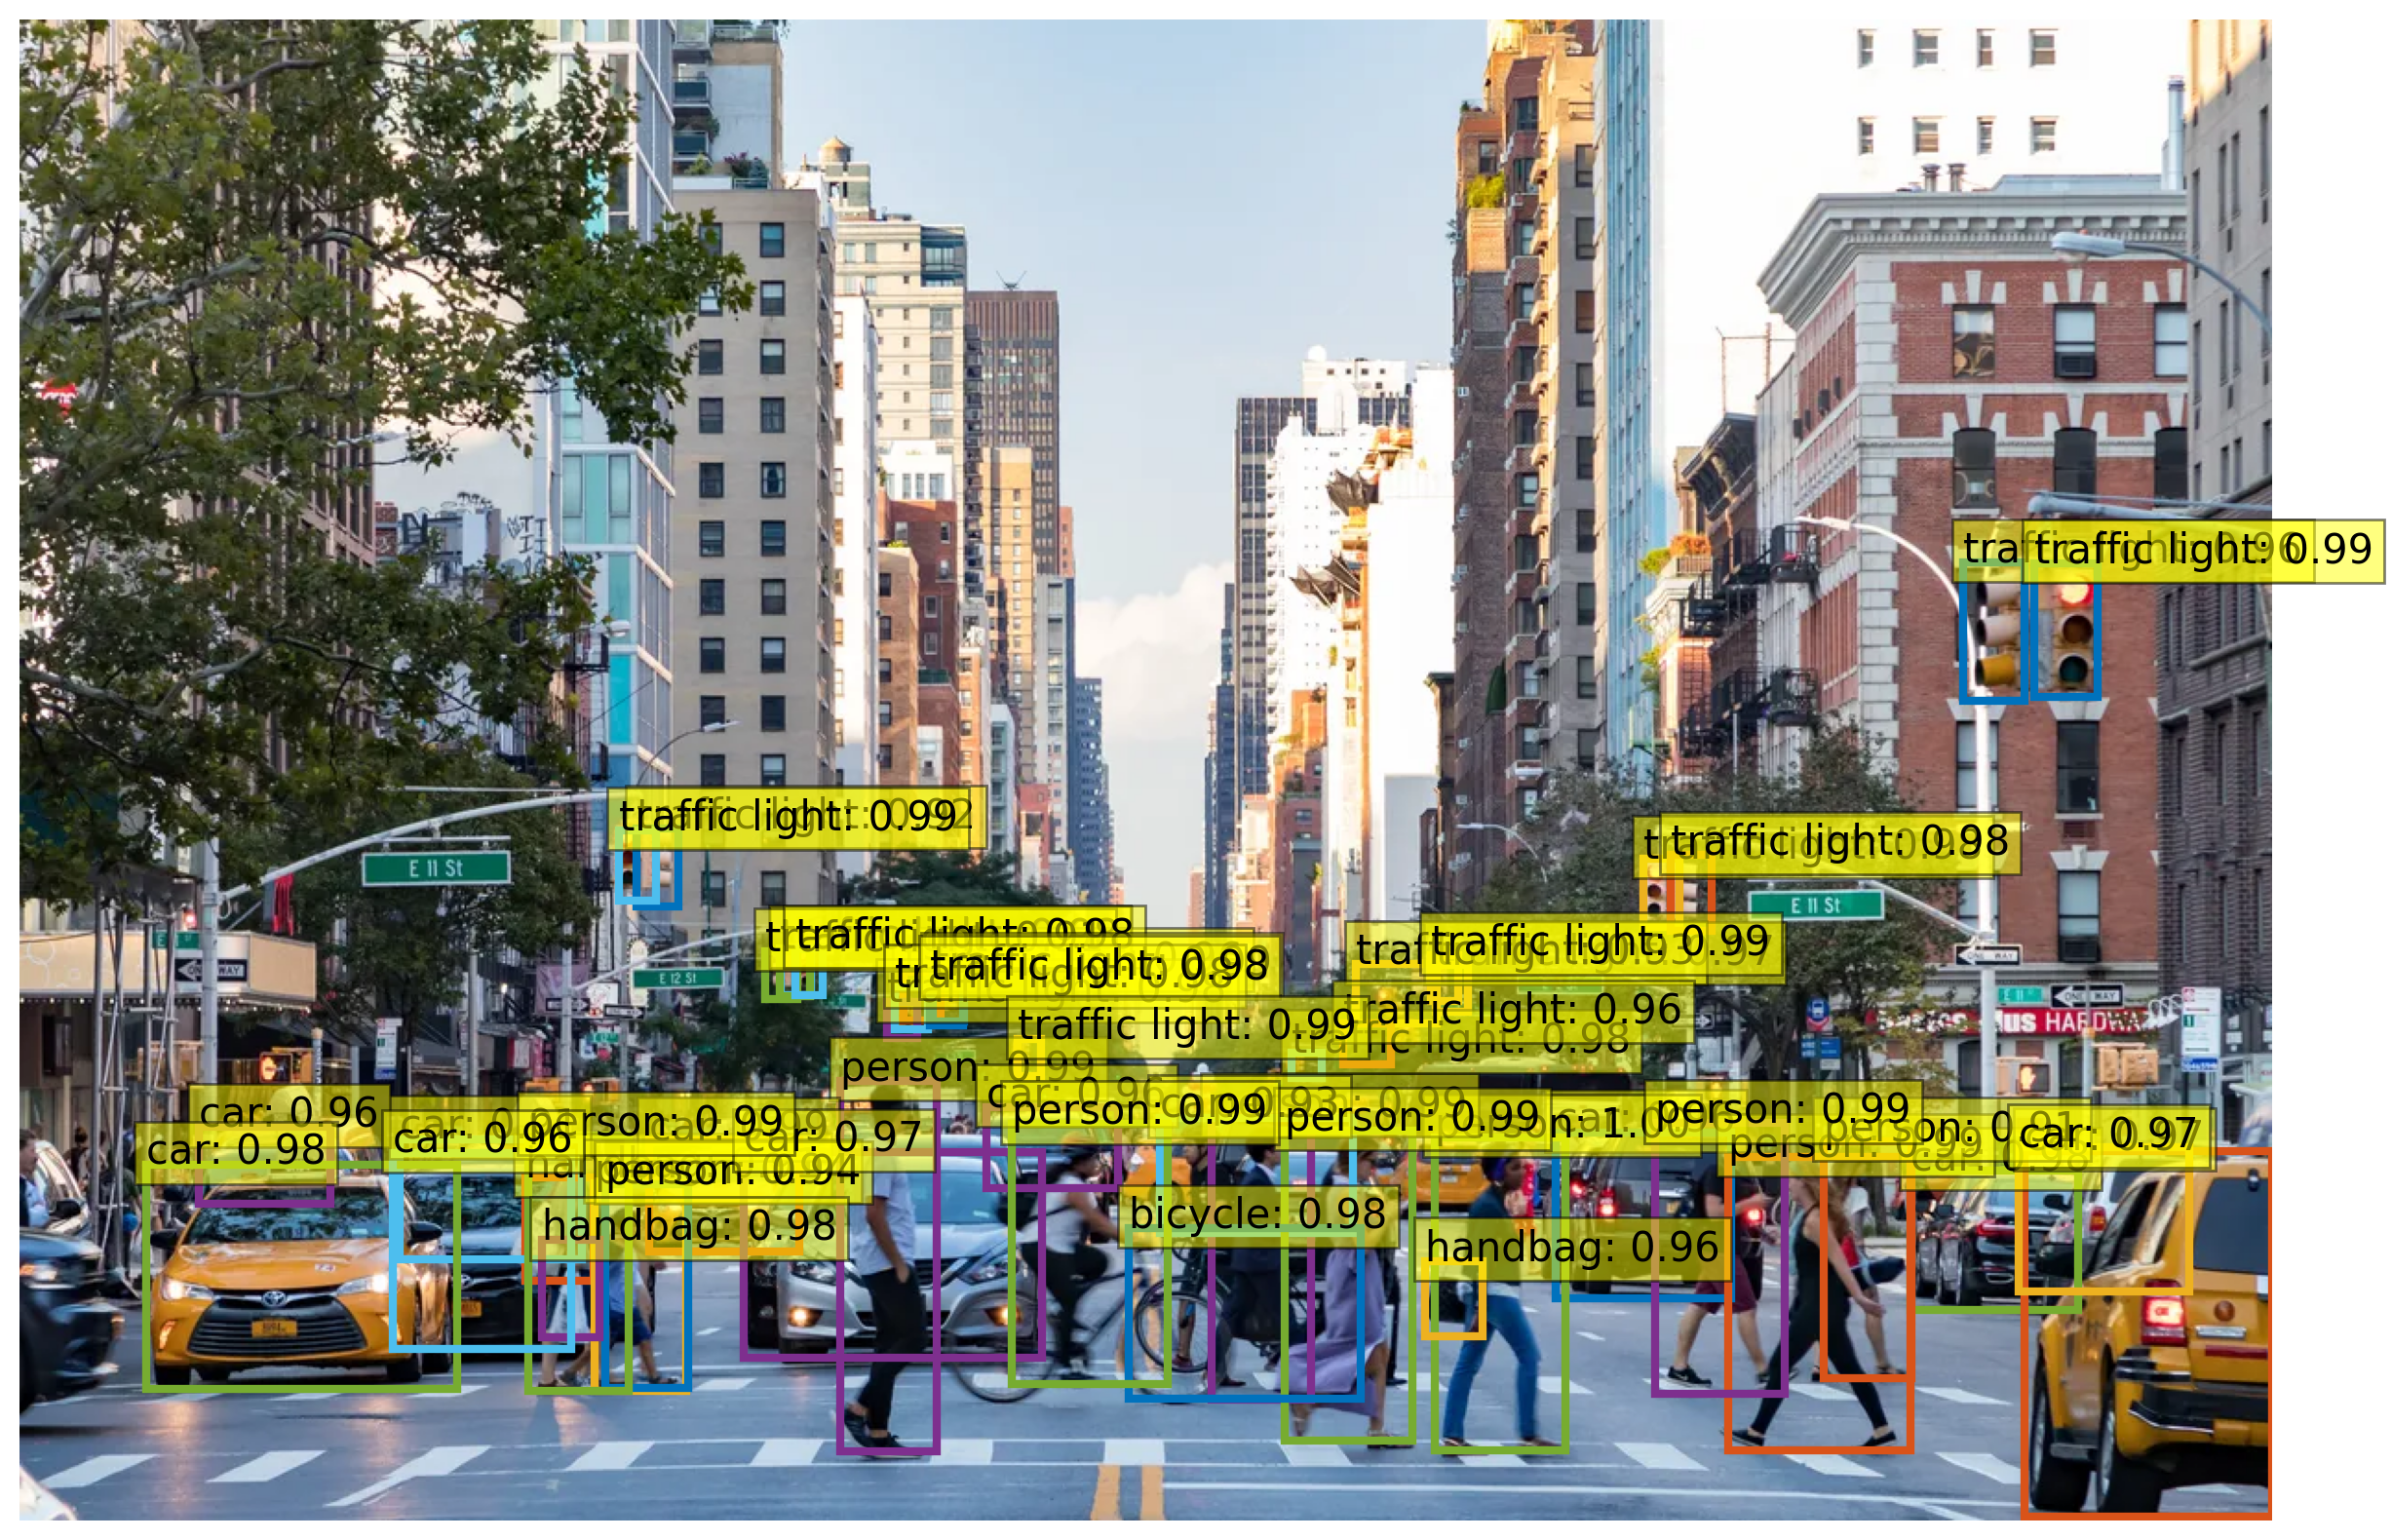

In [19]:
url = 'https://cdn.vox-cdn.com/thumbor/KHxzzBKHqUtm9S1sb4krjisqZbg=/0x0:4000x2667/1220x813/filters:focal(1680x1014:2320x1654):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/65027193/shutterstock_788608396.0.jpg'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, detr, transform)



plot_results(im, scores, boxes)

## Advantages and Limitations
### Advantages
Simplifies the object detection pipeline, handles occlusions and overlapping objects well, and is end-to-end trainable.

### Limitations
DETR can be slower to train due to the global nature of self-attention and might struggle with very small objects.